# Regresión logística

#### <div style="text-align: right"> Berenice Montalvo Lezama </div>

En este ejemplo veremos como implementar regresión logisitica para un atributo. Este modelo se puede ver como la forma más simple de una red neuronal para clasificación, por lo que es importante comprenderlo a profundidad.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

# silenciar TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.random.set_seed(2019)

## Conjunto de datos Iris

Emplearemos un conjunto referencia llamado [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) recolectado por [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) (sí, el mismo del [algoritmo de barajeo](https://en.wikipedia.org/wiki/Fisher%E2%80%93Yates_shuffle) de Fisher-Yates). Este conjunto tiene cuatro atributos de entrada: los anchos y largos de los pétalos y sépalos; y tres clases de flor iris de salida: setosa, versicolour, virginica.

![Pétalo y sépalo](img/iris.png)
<center>Fuente: Suruchi Fialoke, October 13, 2016, Classification of Iris Varieties</center>



Este conjunto tiene 50 muestras de cada clase, leamoslo e imprimamos las primeras cinco de cada clase.

In [2]:
columns = ('largo sépalo', 'ancho sépalo', 'largo pétalo', 'ancho pétalo', 'clase')
df = pd.read_csv('../data/iris/iris.csv', names=columns)
pd.concat((df[1:5], df[50:55], df[100:105]))  

,largo sépalo,ancho sépalo,largo pétalo,ancho pétalo,clase
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
52,6.9,3.1,4.9,1.5,Iris-versicolor
53,5.5,2.3,4.0,1.3,Iris-versicolor
54,6.5,2.8,4.6,1.5,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica


El modelo de regresión logística que entrenaremos resolvera una tarea de clasificación binaria sobre este conjunto considerando únicamente como entrada el largo del peétalo y como salida las dos primeras clases. Grafiquemos la entrada contra la salida para visualizar su relación.

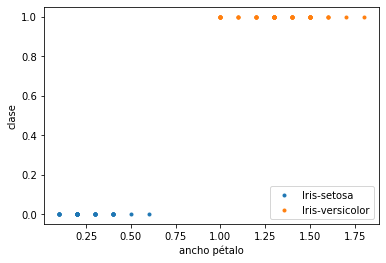

In [3]:
label2index = {'Iris-setosa': 0, 'Iris-versicolor': 1}
x_train = np.array(df.iloc[:, 3][:100])[..., np.newaxis]
y_true_train = [label2index[l] for l in df.iloc[:, -1][:100]]
y_true_train = np.array(y_true_train)[..., np.newaxis]
plt.plot(x_train[:50], y_true_train[:50], '.', label='Iris-setosa')
plt.plot(x_train[50:], y_true_train[50:], '.', label='Iris-versicolor')
plt.xlabel('ancho pétalo')
plt.ylabel('clase')
plt.legend(loc='lower right')
plt.show()

### Quiz 1

¿Cómo podriamos graficar los cuatro atributos de entrada y contra la salida?

## Tuberia de datos

In [4]:
batch_size = 16
ds = tf.data.Dataset.from_tensor_slices((x_train, y_true_train))
ds = ds.shuffle(len(df))
ds = ds.batch(batch_size)

for x, y_true in ds:
    print('x={} x.shape={}'.format(x.numpy().flatten(), x.shape))
    print('y={} y_true.shape={}'.format(y_true.numpy().flatten(), y_true.shape))
    break


W0821 21:14:55.590666 139820299925312 deprecation.py:323] From /home/bere/.virtualenvs/cap/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


x=[0.2 1.2 1.3 0.2 1.3 0.3 0.2 1.5 0.4 0.2 0.2 1.3 0.2 0.2 0.4 0.1] x.shape=(16, 1)
y=[0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0] y_true.shape=(16, 1)


## Definición del modelo

In [5]:
class LogReg(Model):

  def __init__(self):
    super(LogReg, self).__init__()
    self.fc = Dense(1, activation=tf.nn.sigmoid)

  def call(self, x):
    return self.fc(x)

### Quiz 2

¿Qué modelo sencillo podríamos usar para realizar clasificación de las tres clases?

## Definición de pérdida y optimizador

In [6]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)


### Quiz 3

¿Qué función de pérdida podríamos usar para realizar clasificación de las tres clases?

## Definición de métricas

Las clases dentro de `tf.keras.metrics` están diseñadas para mantener un histórico de una métrica a lo largo de los pasas de entrenamiento y agregarlo (con el promedio por ejemplo) para obtener el desempeño de la métrica a nivel epoca.

In [7]:
# historial de pérdidas
train_loss = tf.keras.metrics.BinaryCrossentropy()
# historial de exactitudes
train_acc = tf.keras.metrics.BinaryAccuracy()

### Quiz 4

¿Cómo se define la exactitud?


## Entrenamiento

In [8]:
model = LogReg()

epochs = 20

for epoch in range(epochs):
    
    for x, y_true in ds:
        
        with tf.GradientTape() as tape:
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)            
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(y_true, y_pred)
        train_acc(y_true, y_pred)
    
    loss = train_loss.result() * 100
    acc = train_acc.result() * 100
    train_loss.reset_states()
    train_acc.reset_states()

    print('E{:3d} loss={:6.2f}, acc={:6.2f}'.format(epoch, loss, acc))        

E  0 loss= 71.09, acc= 46.00
E  1 loss= 66.30, acc= 50.00
E  2 loss= 62.66, acc= 52.00
E  3 loss= 59.70, acc= 56.00
E  4 loss= 57.15, acc= 71.00
E  5 loss= 54.88, acc= 84.00
E  6 loss= 52.81, acc= 88.00
E  7 loss= 50.89, acc= 91.00
E  8 loss= 49.10, acc= 91.00
E  9 loss= 47.42, acc= 94.00
E 10 loss= 45.84, acc= 98.00
E 11 loss= 44.35, acc= 98.00
E 12 loss= 42.94, acc= 98.00
E 13 loss= 41.61, acc= 98.00
E 14 loss= 40.34, acc= 99.00
E 15 loss= 39.15, acc= 99.00
E 16 loss= 38.01, acc= 99.00
E 17 loss= 36.93, acc= 99.00
E 18 loss= 35.91, acc= 99.00
E 19 loss= 34.94, acc= 99.00


## Inferencia

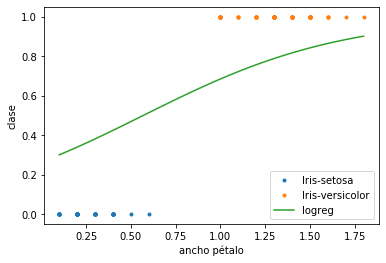

In [9]:
w, b = model.trainable_variables
w, b = w.numpy()[0][0], b.numpy()[0]
sigmoid = lambda x: (1 / (1 + np.exp(-x)))
x_model = np.linspace(x_train[:100].min(), x_train[:100].max(), 100)[..., np.newaxis]
y_model = sigmoid(x_model * w + b)
plt.plot(x_train[:50], y_true_train[:50], '.', label='Iris-setosa')
plt.plot(x_train[50:], y_true_train[50:], '.', label='Iris-versicolor')
plt.plot(x_model, y_model, label='logreg')
plt.xlabel('ancho pétalo')
plt.ylabel('clase')
plt.legend(loc='lower right')
plt.show()

### Quiz 5

¿Qué pasaría con la pérdida, la exactitud y la gráfica de la función sigmoide si entrenamos durante 100 épocas?